# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM


In [ ]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [ ]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [ ]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

In [ ]:
event_types = ['main_track_gate', 'shutter', 'mini2p_frames', 'mini2p_lines', 'mini2p_volumes', 'aux_bpod_cam',
               'aux_bpod_visual', 'aux_bpod_reward', 'aux_bpod_tone']

for e in event_types:
    event.EventType.insert1({'event_type': e, 'event_type_description': ''}, skip_duplicates=True,)

In [ ]:
session.Session()

In [ ]:
scan.Scan()

## Ingesting behavior

In [ ]:
ibe.ingest_aux("sess9FHS7Y22","scan9FHS845A", verbose=True)

In [ ]:
event.BehaviorRecording.File.insert1(["sess9FHS7Y22", "scan9FHS7Y22", "test"], skip_duplicates=True)

In [ ]:
scan_key = (scan.Scan & f'scan_id = "scan9FHS7Y22"').fetch('KEY')

In [ ]:
auxpath = (event.BehaviorRecording.File() & scan_key).fetch('filepath')

In [27]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )

In [29]:
from adamacs.behavior import demultiplex

ModuleNotFoundError: No module named 'adamacs.behavior'

In [38]:
analog_scans = curr_file['sweep_2024']['analogScans']
digital_scans = curr_file['sweep_2024']['digitalScans']

In [72]:
curr_file['header']['AIChannelNames']

array([b'Cam Trigger', b'BPOD 1', b'BPOD 2', b'BPOD tone', b'FlashStim'],
      dtype='|S11')

In [47]:
analog_scans[0][::1000].shape

(12400,)

In [66]:
analog_scans[i][::step]

array([-0.00951613, -0.00951613, -0.00951613, ..., -0.00885827,
       -0.0091872 , -0.00951613])

In [81]:
i

5

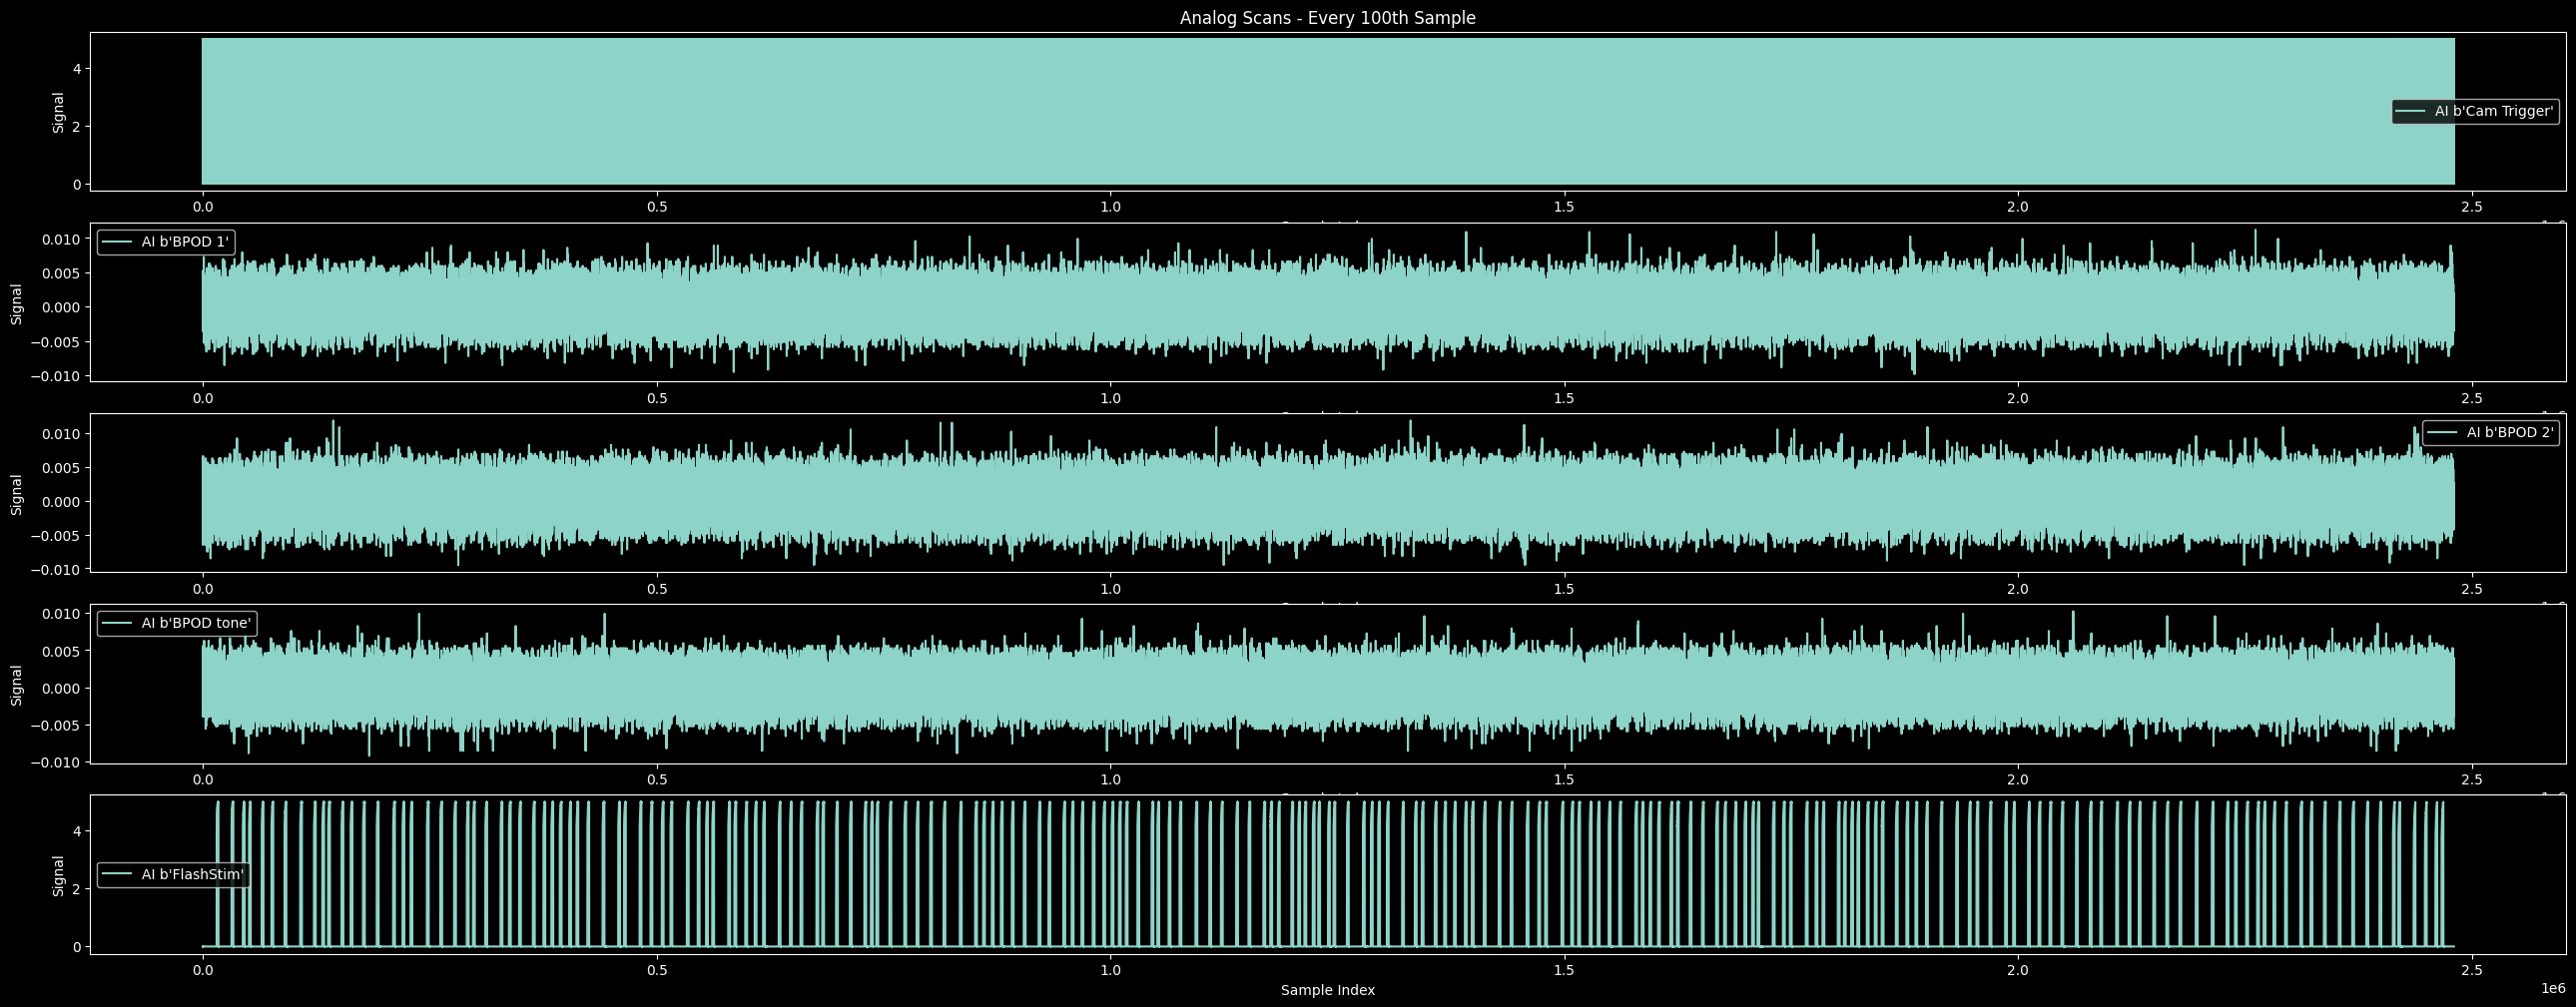

IndexError: index 5 is out of bounds for axis 0 with size 5

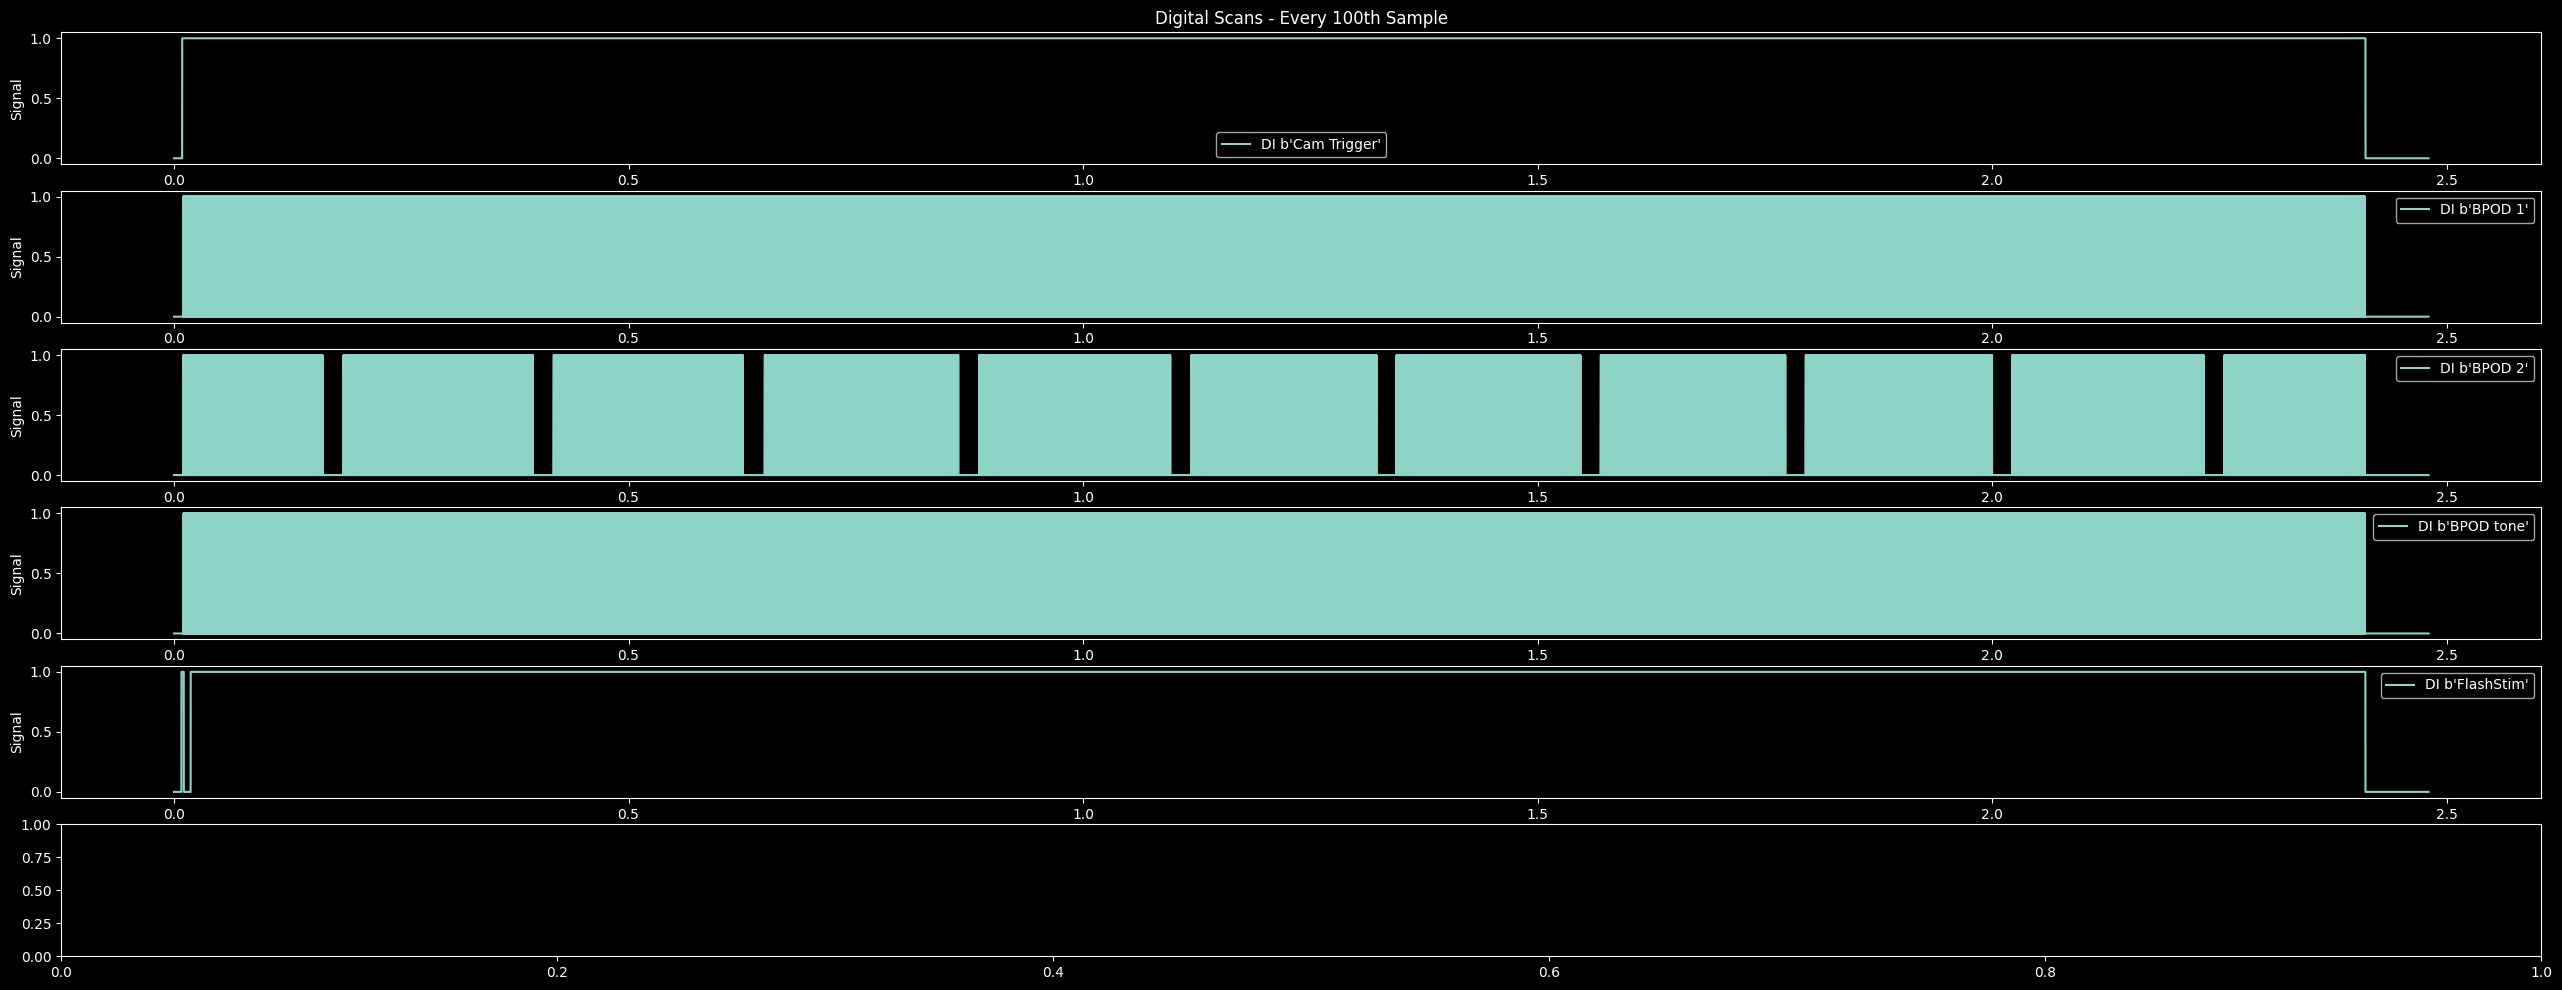

In [82]:
analog_scans = curr_file['sweep_2024']['analogScans']
analog_labels = curr_file['header']['AIChannelNames']
digital_scans = ibe.demultiplex(curr_file['sweep_2024']['digitalScans'][0], 6)
digital_labels = curr_file['header']['DIChannelNames']
step = 5

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(32, 12))

# Plotting analogScans
axes[0].set_title("Analog Scans - Every 100th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(32, 12))

# Plotting analogScans
axes[0].set_title("Digital Scans - Every 100th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
plt.show()


In [35]:
analog_scans[i::step]

array([[-3.06067262e-04,  4.99023824e+00,  4.99089611e+00, ...,
        -3.06067262e-04, -9.63928787e-04, -6.34998025e-04]])

In [32]:
digital_channels = ibe.demultiplex(curr_file['sweep_2024']
['digitalScans'][0], 6)
main_track_gate_chan = digital_channels[4]
shutter_chan = digital_channels[3]
mini2p_frame_chan = digital_channels[2]
mini2p_line_chan = digital_channels[1]
mini2p_vol_chan = digital_channels[0]
mini2p_vol_chanXXX = digital_channels[5]

In [ ]:
curr_aux

In [ ]:
event.BehaviorRecording.File()

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
from pywavesurfer import ws

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)
curr_file = ws.loadDataFile(filename=fp[0], format_string='double' )


In [ ]:
scan.Scan()

In [ ]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)

In [ ]:
event.AlignmentEvent()

In [ ]:
trial.Trial()

In [ ]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

In [ ]:
scan.ScanInfo.populate()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()